In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
from skimage.io import imread
from skimage.transform import resize
import PIL
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.image as mpimg
import tensorflow as tf
print(tf.__version__)
from style_stack import StyleStack
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image



2.15.0


In [7]:
pip install --upgrade scipy scikit-image


Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import faiss
from utils import *
import pickle


## Loading Model

In [3]:
data_dir = pathlib.Path('C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data')

IMG_SIZE = (224, 224)
batch_size = 50

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 415 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [6]:
weights_file = 'C:\\Users\\krnps\\MODERN\\vgg16_furniture_classifier_1129.h5'

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [8]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.load_weights(weights_file)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Preparing images path

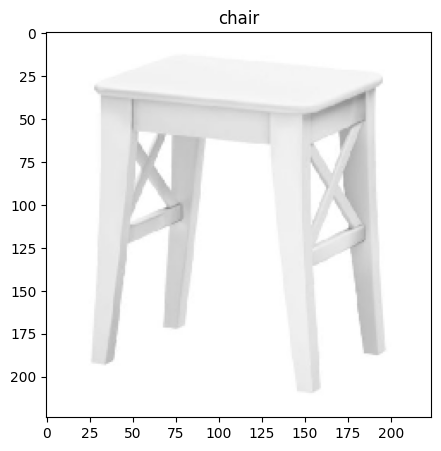

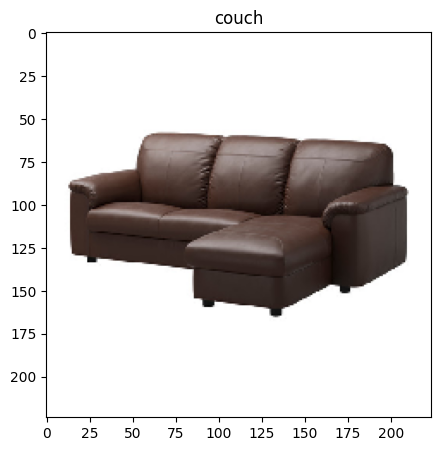

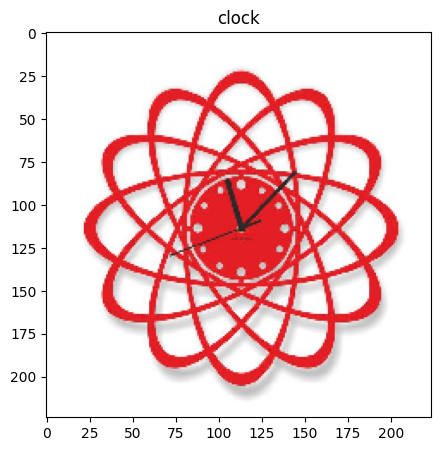

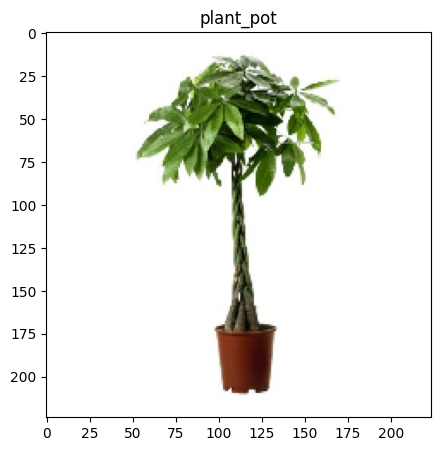

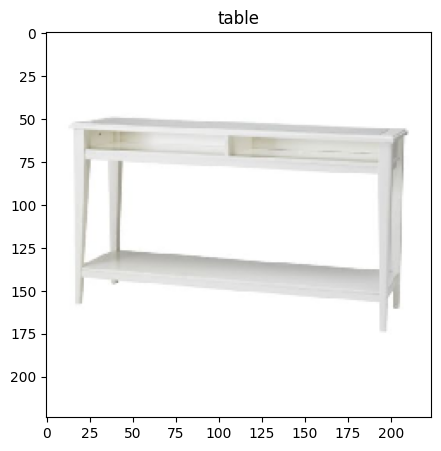

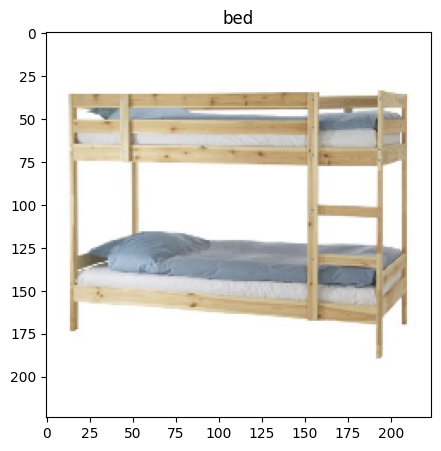

In [12]:
data_dir = pathlib.Path('C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data')

def get_img_by_class(dir_, class_list):
    img_by_class = {}
    for class_ in class_list:
        paths = glob.glob(os.path.join(dir_, f'{class_}/*'))
        img_by_class[class_] = paths
    return img_by_class


def preview_img_by_class(img_by_class):
    for class_, paths in img_by_class.items():
        img, _ = load_image(paths[0], (224, 224))
        plt.figure(figsize = (5, 5))
        plt.imshow(img)
        plt.title(class_)

dir_ = 'C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data'

styles = [
    'chair',
    'couch',
    'clock',
    'plant_pot',
    'table',
    'bed'
]
                          
art_by_style = get_img_by_class(dir_, styles)
preview_img_by_class(art_by_style)

1/1 [==============================] - 0s 379ms/step
predicted objects and probabilities
chair 0.0
couch 0.0
clock 1.0
plant_pot 0.0
table 0.0
bed 0.0


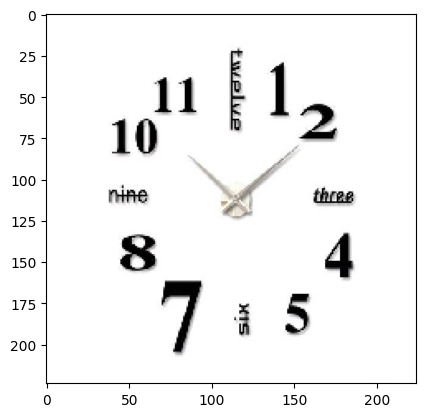

In [13]:
classes =['chair','couch','clock','plant_pot','table','bed']
     
img, x = load_image(art_by_style['clock'][2], (224, 224))
plt.imshow(img)
predictions = model.predict(x)
print('predicted objects and probabilities')
for class_, prob in zip(classes, *predictions):
    print(class_, prob)


## Recommendations

1/1 [==============================] - 0s 308ms/step


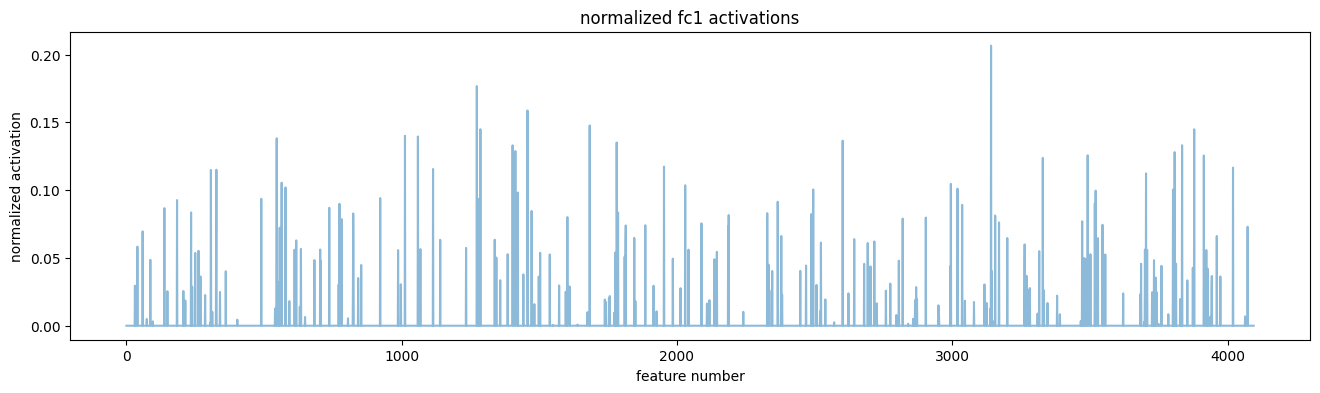

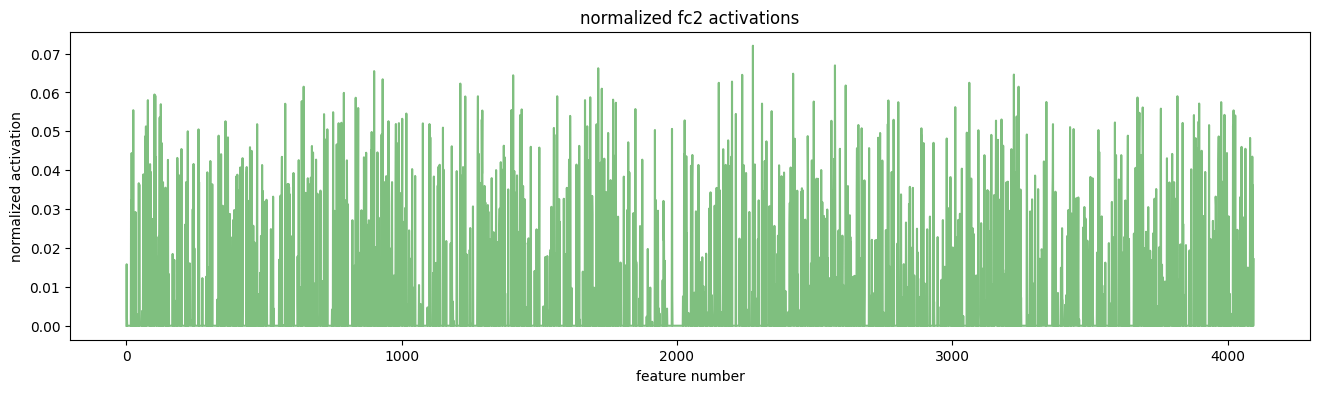

In [14]:
fc1_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc1').output)
fc2_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc2').output)
fc1_a = fc1_extractor.predict(x)
fc2_a = fc2_extractor.predict(x)
fc1_norm = preprocessing.normalize(fc1_a, norm='l2')
fc2_norm = preprocessing.normalize(fc2_a, norm='l2')
plt.figure(figsize=(16, 4))
plt.plot(fc1_norm[0], alpha=0.5)
plt.title('normalized fc1 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.figure(figsize=(16, 4))
plt.plot(fc2_norm[0], color='green', alpha=0.5)
plt.title('normalized fc2 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.show()

In [15]:
all_paths = [path for paths in list(art_by_style.values()) for path in paths]
file_mapping = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_2 = fc2_extractor.predict(X)
V_1_norm = preprocessing.normalize(V_1, norm='l2')
V_2_norm = preprocessing.normalize(V_2, norm='l2')

17/17 [==============================] - 29s 2s/step


In [17]:
all_paths = [path for path in list(art_by_style['chair'])]
file_mapping_chairs = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_chair = preprocessing.normalize(V_1, norm='l2')


5/5 [==============================] - 8s 1s/step


In [19]:
pickle.dump(file_mapping_chairs, open('C:\\Users\\krnps\\MODERN\\file_mapping_chairs.p', 'wb'))
pickle.dump(V_1_norm_chair, open('C:\\Users\\krnps\\MODERN\\V_1_norm_chair.p', 'wb'))

## Extract feature and normalize vectors for specific category of furnitures

In [21]:
all_paths = [path for path in list(art_by_style['couch'])]
file_mapping_coffee_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_coffee_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_coffee_tables, open('C:\\Users\\krnps\\MODERN\\file_mapping_couch.p', 'wb'))
pickle.dump(V_1_norm_coffee_tables, open('C:\\Users\\krnps\\MODERN\\V_1_norm_couch.p', 'wb'))

2/2 [==============================] - 2s 600ms/step


In [22]:
all_paths = [path for path in list(art_by_style['plant_pot'])]
file_mapping_console_table = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_console_table = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_console_table, open('C:\\Users\\krnps\\MODERN\\file_mapping_plant_pot.p', 'wb'))
pickle.dump(V_1_norm_console_table, open('C:\\Users\\krnps\\MODERN\\V_1_norm_plant_pot.p', 'wb'))


2/2 [==============================] - 2s 155ms/step


In [23]:
all_paths = [path for path in list(art_by_style['table'])]
file_mapping_dining_chair = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_dining_chair = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_dining_chair, open('C:\\Users\\krnps\\MODERN\\file_mapping_table.p', 'wb'))
pickle.dump(V_1_norm_dining_chair, open('C:\\Users\\krnps\\MODERN\\V_1_norm_table.p', 'wb'))


5/5 [==============================] - 7s 1s/step


In [54]:
all_paths = [path for path in list(art_by_style['clock'])]
file_mapping_dining_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_dining_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_dining_tables, open('C:\\Users\\krnps\\MODERN\\file_mapping_clock.p', 'wb'))
pickle.dump(V_1_norm_dining_tables, open('C:\\Users\\krnps\\MODERN\\V_1_norm_clock.p', 'wb'))


TypeError: 'NoneType' object cannot be interpreted as an integer

In [25]:
all_paths = [path for path in list(art_by_style['bed'])]
file_mapping_end_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_end_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_end_tables, open('C:\\Users\\krnps\\MODERN\\file_mapping_bed.p', 'wb'))
pickle.dump(V_1_norm_end_tables, open('C:\\Users\\krnps\\MODERN\\V_1_norm_bed.p', 'wb'))


2/2 [==============================] - 4s 2s/step


In [287]:
all_paths = [path for path in list(art_by_style['lamp'])]
file_mapping_lamp = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_lamp = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_lamp, open('file_mapping/lamp/file_mapping_lamp.p', 'wb'))
pickle.dump(V_1_norm_lamp, open('file_mapping/lamp/V_1_norm_lamp.p', 'wb'))


In [289]:
all_paths = [path for path in list(art_by_style['ottomans'])]
file_mapping_ottomans = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_ottomans = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_ottomans, open('file_mapping/ottomans/file_mapping_ottomans.p', 'wb'))
pickle.dump(V_1_norm_ottomans, open('file_mapping/ottomans/V_1_norm_ottomans.p', 'wb'))

In [218]:
all_paths = [path for path in list(art_by_style['rug'])]
file_mapping_rug = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_rug = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_rug, open('file_mapping/rug/file_mapping_rug.p', 'wb'))
pickle.dump(V_1_norm_rug, open('file_mapping/rug/V_1_norm_rug.p', 'wb'))


In [219]:
all_paths = [path for path in list(art_by_style['sofa'])]
file_mapping_sofa = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_sofa = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_sofa, open('file_mapping/sofa/file_mapping_sofa.p', 'wb'))
pickle.dump(V_1_norm_sofa, open('file_mapping/sofa/V_1_norm_sofa.p', 'wb'))


In [220]:
all_paths = [path for path in list(art_by_style['tv stand'])]
file_mapping_tv_stand = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_tv_stand = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_tv_stand, open('file_mapping/tv stand/file_mapping_tv_stand.p', 'wb'))
pickle.dump(V_1_norm_tv_stand, open('file_mapping/tv stand/V_1_norm_tv_stand.p', 'wb'))


## Testing how feature extractors work with recommending furnitures

In [29]:
def similarity_search(V, v_query, file_mapping, n_results=6):
    v_query = np.expand_dims(v_query, axis=0)
    d = V.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(np.ascontiguousarray(V))
    distances, closest_indices = index.search(v_query, n_results)
    distances = distances.flatten()
    closest_indices = closest_indices.flatten()
    closest_paths = [file_mapping[idx] for idx in closest_indices]
    #query_img = get_concatenated_images([file_mapping[query_idx]])
    results_img = get_concatenated_images(closest_paths[1:])
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(compare)
    # plt.title('query image')

    plt.figure(figsize=(16, 12))
    plt.imshow(results_img)
    plt.title(f'results similarities: {distances}')
    plt.show()

def image_upload(img, target_size):
    img = ImageOps.fit(img, target_size, Image.LANCZOS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x    

1/1 [==============================] - 0s 160ms/step


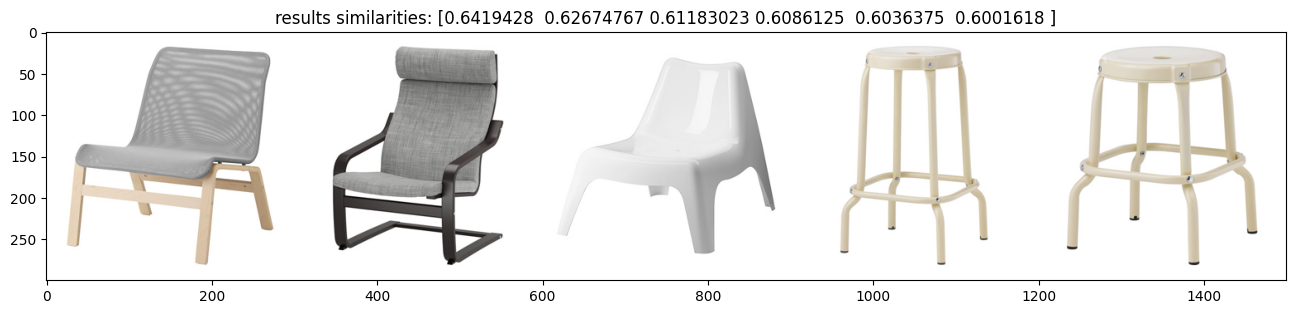

In [30]:
compare = preprocessing.normalize(
        fc1_extractor.predict(image_upload(Image.open('C:\\Users\\krnps\\furnish.ai\\webapp\\static\\uploads\\h.jpg'), model.input_shape[1:3])[1]), norm="l2",
    ).reshape(4096,)
similarity_search(V_1_norm, compare, file_mapping)



1/1 [==============================] - 0s 157ms/step


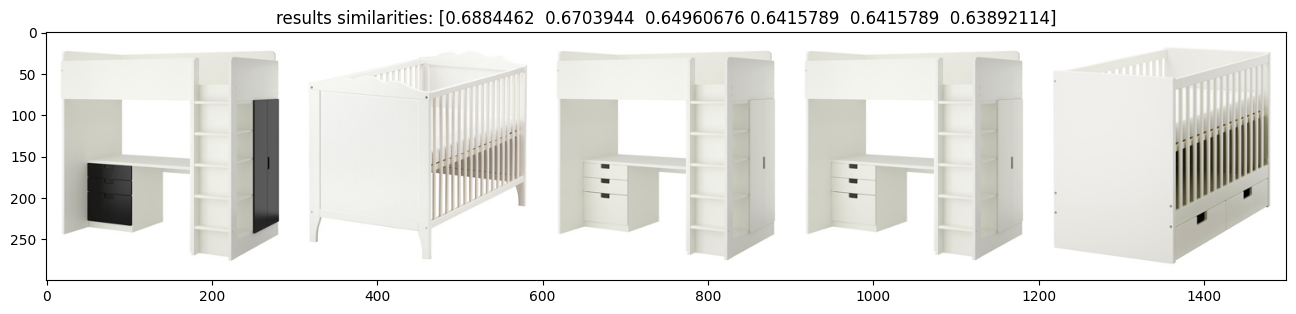

In [34]:
compare = preprocessing.normalize(
        fc1_extractor.predict(image_upload(Image.open('C:\\Users\\krnps\\furnish.ai\\webapp\\static\\styles\\Modern.jpg'), model.input_shape[1:3])[1]), norm="l2",
    ).reshape(4096,)
similarity_search(V_1_norm, compare, file_mapping)



## Using StyleStack to query results

In [45]:
from tensorflow.keras.applications import VGG16

stack = StyleStack.build('C:\\Users\\krnps\\Downloads\\Deep-learning-recommender-main\\Deep-learning-recommender-main\\data\\chair', 'vgg16')


keeping 134 image_paths to analyze
Embedding error: ('Layer "model_9" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=\narray([[[[151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         ...,\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ]],\n\n        [[151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         ...,\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ]],\n\n        [[151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.22101, 131.32   ],\n         ...,\n         [151.061  , 138.22101, 131.32   ],\n         [151.061  , 138.2210

ValueError: need at least one array to stack

In [53]:
from tensorflow import keras
model = keras.applications.VGG16(weights='imagenet', include_top=False)
print("✅ VGG16 Model loaded!")


✅ VGG16 Model loaded!


In [363]:
stack1 = StyleStack.build('images/chairs', 'vgg16')

keeping 466 image_paths to analyze
index time: 277.067 ms


In [370]:
stack2 = StyleStack.build('images/sofa', 'vgg16')

keeping 479 image_paths to analyze
index time: 361.365 ms


In [39]:
embedding_weights = {
        'block1_conv1': 1,
        'block1_conv2': 1,
        'block1_pool': 0.5
        
}

results = stack.query('C:\\Users\\krnps\\furnish.ai\\webapp\\static\\uploads\\h.jpg', embedding_weights)

NameError: name 'stack' is not defined

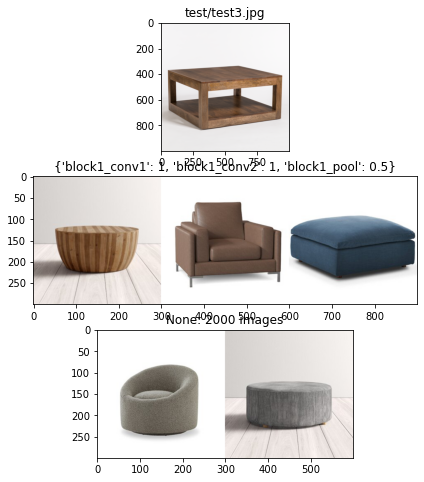

In [451]:
plot_results(results)